In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import pylab as plb
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
import plotfuncs as plf
plb.rcParams['pdf.fonttype'] = 42
plb.rcParams['image.interpolation'] = 'nearest'
plb.rcParams['image.aspect'] = 'auto'
plb.rcParams['image.cmap'] = 'BrBG'
import h5py
demo_mode = True

In [2]:
filter_mode = 'non_linear'

In [3]:
ls

01_saccade_annotation.ipynb         saccade_analysis_data_backup.hdf5
02_evaluate_ground_truth.ipynb      saccade_analysis_data.hdf5
03_apply_detector.ipynb             saccade_classifier_param_search.hdf5
03_plot_saccade_responses.ipynb     saccade_evaluation.pdf
chosen_filter_settings_backup.cpkl  STA_kde_bottom30_39E01.pdf
chosen_filter_settings.cpkl         STA_kde_bottom30.pdf
detected_saccades_lin_backup.hdf5   STA_kde_top30_39E01.pdf
detected_saccades_nl_39E01.hdf5     STA_kde_top30.pdf
detected_saccades_nl_backup.hdf5    STAs_desciles_39E01.pdf
detected_saccades_nl.hdf5           STAs_desciles.pdf
detection_approach.pdf              STAs_extrema_rasters_hg1.pdf
fiter_settings.cpkl                 STAs_extrema_rasters.pdf
saccade_analysis_copy.ipynb


In [15]:
saccade_tables_39E01 = h5py.File('detected_saccades_nl_39E01.hdf5','r')
saccade_tables_22H05 = h5py.File('detected_saccades_nl.hdf5','r')

In [16]:
#sort_sig = saccade_tables['filtered'][:,20]
sort_sig_22H05 = saccade_tables_22H05['Ph2'][:,20] - np.mean(saccade_tables_22H05['Ph2'][:,:10],axis = 1)
sort_sig_39E01 = saccade_tables_39E01['Ph2'][:,20] - np.mean(saccade_tables_39E01['Ph2'][:,:10],axis = 1)

In [18]:
sort_idx_22H05 = np.argsort(sort_sig_22H05,axis = 0)
sort_idx_39E01 = np.argsort(sort_sig_39E01,axis = 0)

In [7]:
#plb.imshow(np.array(saccade_tables['filtered'])[sort_idx,:],aspect='auto',vmin = -4,vmax = 4)

In [19]:
#create dict of sorted trials in memory
sorted_saccades_22H05 = dict()
[sorted_saccades_22H05.update({sig:np.array(saccade_tables_22H05[sig])[sort_idx_22H05]}) for 
                                                sig in saccade_tables_22H05.keys()];
sorted_saccades_39E01 = dict()
[sorted_saccades_39E01.update({sig:np.array(saccade_tables_39E01[sig])[sort_idx_39E01]}) for 
                                                sig in saccade_tables_39E01.keys()];

### first look at the saccade triggered averages - broken into desciles according to response magnitude

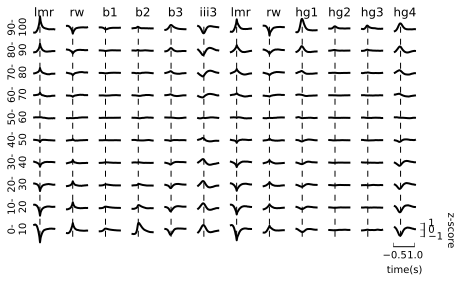

In [31]:
#signals to plot
trace_keys = ['Ph2','Ph1','b1','b2','b3','iii3','Ph2', 'Ph1','hg1','hg2','hg3','hg4']
#break up the saccade responses by desciles
quantile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],11).astype(int)[::-1]
quantile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],11).astype(int)[::-1]

def show_saccade_quantile(col,row):
    """plot function for saccade quantile plots"""
    if col<5:
        sorted_saccades = sorted_saccades_22H05
        quantile_ranges = quantile_ranges_22H05
    else:
        sorted_saccades = sorted_saccades_39E01
        quantile_ranges = quantile_ranges_39E01

    range_start = quantile_ranges[row+1]
    range_stop = quantile_ranges[row]
    data_chunk = np.array(sorted_saccades[trace_keys[col]][range_start:range_stop,:])
    data_chunk -= np.mean(data_chunk,axis = 1)[:,np.newaxis]
    plb.plot(np.linspace(-20*.021,50*.021,np.shape(data_chunk)[1]),
             np.nanmean(data_chunk,axis = 0),
             'k',lw = 2,clip_on = False)

rows = 10
cols = len(trace_keys)
show_spines_right = [False]*rows;show_spines_right[-1] = True
show_spines_bottom = [False]*cols;show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'time(s)'
row_labels_right = [None]*rows;row_labels_right[-1] = 'z-score'
row_labels_left = ['%s-\n%s'%(p) for p in zip(range(90,-10,-10),range(100,0,-10))]
import copy as cp
col_labels_top =  cp.copy(trace_keys)

col_labels_top[0] = 'lmr';
col_labels_top[1] = 'rw';
col_labels_top[6] = 'lmr';
col_labels_top[7] = 'rw';

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = show_saccade_quantile,
                                  figsize = (6.5,4.0),
                                  xbounds = (-.5,1),
                                  ybounds = (-1,1),
                                  row_labels_left = row_labels_left,
                                  row_labels_right = row_labels_right,
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'color':'k','ls':'--'},
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom)

plb.savefig('STAs_desciles_39E01.pdf')

### How does the mean emerge from the single trial data - look at rasters for the two larger desciles, it appears that in some muscles saccade magnitude is reflected by changes in the probability of responses.

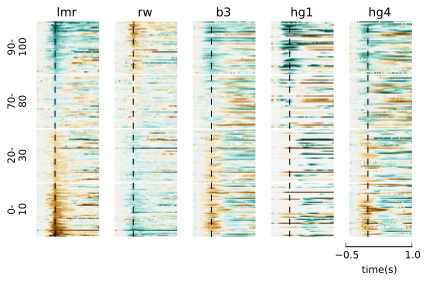

In [42]:
#trace_data = [traces_lmr,traces_rw,traces_b2,traces_b3,traces_i1]
trace_keys = ['Ph2','Ph1','b3','hg1','hg4']

quantile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],11).astype(int)[::-1]
quantile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],11).astype(int)[::-1]

def show_saccade_img(col,row):
    """plot function for saccade quantile plots"""
    imdx = 30
    if row == 0:
        range_start = quantile_ranges_39E01[1]
        range_stop = quantile_ranges_39E01[0]
    if row == 1:
        range_start = quantile_ranges_39E01[3]
        range_stop = quantile_ranges_39E01[2]
    if row == 2:
        range_start = quantile_ranges_39E01[-3]
        range_stop = quantile_ranges_39E01[-4]
    if row == 3:
        range_start = quantile_ranges_39E01[-1]
        range_stop = quantile_ranges_39E01[-2]

    data_chunk = np.array(sorted_saccades_39E01[trace_keys[col]][range_start:range_stop,:])
    data_chunk -= np.mean(data_chunk[:,:10],axis = 1)[:,np.newaxis]
    plb.imshow(data_chunk[::imdx][::-1],
       aspect = 'auto',interpolation = 'nearest',
       vmin =-3,vmax = 3,
       extent = [-20*.021,50*.021,-4,4],
       cmap = plb.cm.BrBG)

rows = 4
cols = 5

show_spines_right = [False]*rows;show_spines_right[0] = True
show_spines_bottom = [False]*cols;show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'time(s)'
row_labels_left = ['%s-\n%s'%(p) for p in [(90,100),(70,80),(20,30),(0,10)]]
col_labels_top = ['lmr','rw','b3','hg1','hg4']

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = show_saccade_img,
                                  figsize = (6.0,4.0),
                                  xbounds = (-.5,1),
                                  ybounds = (-4,4),
                                  row_labels_left = row_labels_left,
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  show_spines_right = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_bottom = show_spines_bottom)
[ax.set_zorder(np.inf) for ax in col_epoch_panels]
#plb.show()
plb.savefig('STAs_extrema_rasters_39E01.pdf')

### to quantify this effect I made histograms of the response magnitude this time broken down in 5 percentile brackets

In [11]:
if not(demo_mode):
    signals_to_search = ['Ph2','Ph1','b1','b2','b3','i1','i2','hg1','hg4']

    percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
    top30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[5:35:5],percentile_ranges_22H05[0:30:5])
    bottom30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[74:105:5],percentile_ranges_22H05[70:100:5])
    bw_search = list()

    from sklearn.neighbors import KernelDensity
    from sklearn.grid_search import GridSearchCV

    for bracket in range(6):
        range_start,range_stop = top30_percentile_brackets[bracket]
        for sig in signals_to_search:
            data_chunk = np.array(sorted_saccades[sig][range_start:range_stop,:])
            X = np.mean(data_chunk[:,18:22],axis = 1)[:, np.newaxis]
            grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.1, 1.0, 30)},
                        cv=20) # 20-fold cross-validation
            grid.fit(X)
            bw =  grid.best_params_['bandwidth']
            bw_search.append(bw)

    for bracket in range(6):
        range_start,range_stop = top30_percentile_brackets[bracket]
        for sig in signals_to_search:
            print sig
            data_chunk = np.array(sorted_saccades[sig][range_start:range_stop,:])
            X = np.mean(data_chunk[:,18:22],axis = 1)[:, np.newaxis]
            grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.1, 1.0, 30)},
                        cv=20) # 20-fold cross-validation
            grid.fit(X)
            bw =  grid.best_params_['bandwidth']
            bw_search.append(bw)
    bandwidth = np.mean(bw_search)        
    print np.mean(bw_search)
else:
    percentile_ranges = np.linspace(0,np.shape(sorted_saccades['Ph2'])[0],100).astype(int)[::-1]
    top30_percentile_brackets = zip(percentile_ranges[5:35:5],percentile_ranges[0:30:5])
    bottom30_percentile_brackets = zip(percentile_ranges[74:105:5],percentile_ranges[70:100:5])
    bandwidth = 0.365862068966

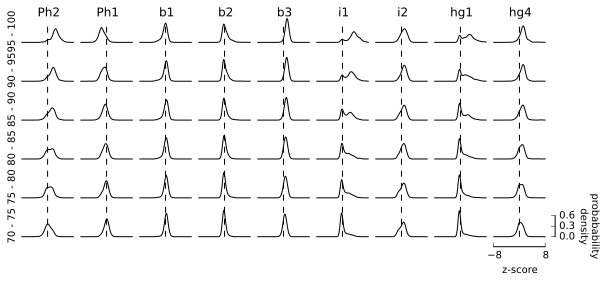

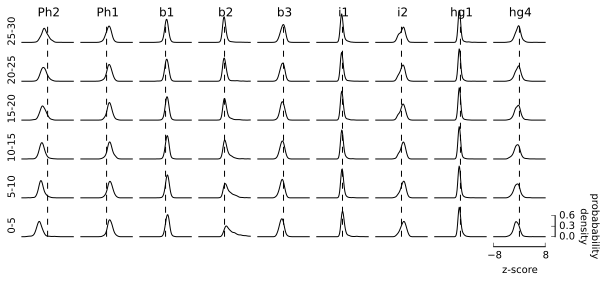

In [39]:
reload(plf)
trace_keys = ['Ph2','Ph1','b1','b2','b3','i1','i2','hg1','hg4']

percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
top30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[5:35:5],percentile_ranges_22H05[0:30:5])
bottom30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[74:105:5],percentile_ranges_22H05[70:100:5])

percentile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],100).astype(int)[::-1]
top30_percentile_brackets_39E01 = zip(percentile_ranges_39E01[5:35:5],percentile_ranges_39E01[0:30:5])
bottom30_percentile_brackets_39E01 = zip(percentile_ranges_39E01[74:105:5],percentile_ranges_39E01[70:100:5])

def get_kde(data_chunk):
    from sklearn.neighbors import KernelDensity
    X = np.mean(data_chunk[:,18:22],axis = 1)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
    X_plot = np.linspace(-8, 8, 100)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    return X_plot,np.exp(log_dens)

def plot_top30_percentiles(col,row):
    if col < 7:
        range_start,range_stop = top30_percentile_brackets_22H05[row]
        data_chunk = sorted_saccades_22H05[trace_keys[col]][range_start:range_stop,:]
    else:
        range_start,range_stop = top30_percentile_brackets_39E01[row]
        data_chunk = sorted_saccades_39E01[trace_keys[col]][range_start:range_stop,:]
    plb.plot(*get_kde(data_chunk),color = 'k',clip_on = False)
    
def plot_bottom30_percentiles(col,row):
    if col < 7:
        range_start,range_stop = bottom30_percentile_brackets_22H05[row]
        data_chunk = sorted_saccades_22H05[trace_keys[col]][range_start:range_stop,:]
    else:
        range_start,range_stop = bottom30_percentile_brackets_39E01[row]
        data_chunk = sorted_saccades_39E01[trace_keys[col]][range_start:range_stop,:]
    plb.plot(*get_kde(data_chunk),color = 'k',clip_on = False)

rows = 6
cols = len(trace_keys)
show_spines_right = [False]*rows; show_spines_right[-1] = True
show_spines_bottom = [False]*cols; show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'z-score'
row_labels_right = [None]*rows;row_labels_right[-1] = 'probabability \ndensity'

col_labels_top =  cp.copy(trace_keys)

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = plot_top30_percentiles,
                                  figsize = (8.5,4),
                                  xbounds = (-8,8),
                                  ybounds = (0,0.6),
                                  row_labels_left = ['%s - %s'%(p) for 
                                                     p in zip(range(70,100,5),range(75,105,5))[::-1]],
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom,
                                  row_labels_right = row_labels_right)
plb.savefig('STA_kde_top30_39E01.pdf')

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = plot_bottom30_percentiles,
                                  figsize = (8.5,4),
                                  xbounds = (-8,8),
                                  ybounds = (0,0.6),
                                  row_labels_left = ['%s-%s'%(p) for 
                                                     p in zip(range(0,30,5),range(5,35,5))[::-1]],
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom,
                                  row_labels_right = row_labels_right)
plb.savefig('STA_kde_bottom30_39E01.pdf')